# Blue Qubit (Deteqt team)


In [ ]:
!pip install qiskit
!pip install qiskit_ibm_runtime

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from typing import Optional, Dict
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class QuantumCircuitAnalyzer:
    def __init__(self, ibm_token: str, instance: Optional[str] = None, backend_name: str = 'ibm_sherbrooke',
                 resilience_level: int = 2):
        """
        Initialize IBM Quantum analyzer with error mitigation support.

        Args:
            ibm_token (str): IBM Quantum API token
            instance (str, optional): Your IBM Quantum instance (e.g. 'ibm-q/open/main')
            backend_name (str): Target backend name (default: 'ibm_sherbrooke')
            resilience_level (int): Error mitigation level (0 = none, 1~3 = increasing strength)
        """
        if instance:
            self.service = QiskitRuntimeService(channel="ibm_cloud", token=ibm_token, instance=instance)
        else:
            self.service = QiskitRuntimeService(channel="ibm_cloud", token=ibm_token)

        self.backend = self.service.backend(backend_name)
        self.session = Session(backend=self.backend)
        self.sampler = Sampler(session=self.session, options={
            "resilience_level": resilience_level,
            "default_shots": 10000
        })

        self.circuit = None
        self.tp_circuit = None
        self.results = None
        self.probabilities = None
        self.job_id = None

    def load_qasm_circuit(self, qasm_file_path: str) -> QuantumCircuit:
        self.circuit = QuantumCircuit.from_qasm_file(qasm_file_path)
        if 'measure' not in self.circuit.count_ops():
            self.circuit.measure_all()
        print(f"🌀 Loaded {self.circuit.num_qubits}-qubit circuit with {len(self.circuit)} gates")
        return self.circuit

    def optimize_circuit(self, optimization_level: int = 2) -> QuantumCircuit:
        pm = generate_preset_pass_manager(optimization_level, backend=self.backend)
        self.tp_circuit = pm.run(self.circuit)
        print(f"✅ Optimization done: depth {self.circuit.depth()} → {self.tp_circuit.depth()}")
        return self.tp_circuit

    def execute_circuit(self) -> Dict[str, float]:
        job = self.sampler.run([self.tp_circuit])
        self.job_id = job.job_id()
        print(f"📦 Job submitted (ID: {self.job_id})")
        result = job.result()
        counts = result[0].data.meas.get_counts()
        self.results = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
        self._calculate_probabilities()
        return self.results

    def _calculate_probabilities(self) -> None:
        total_shots = sum(self.results.values())
        self.probabilities = sorted(
            {k: v / total_shots for k, v in self.results.items()}.items(),
            key=lambda x: x[1], reverse=True
        )

    def visualize_results(self, top_n: int = 20) -> None:
        if not self.probabilities:
            raise ValueError("No results to visualize")

        top_bitstrings = [b for b, _ in self.probabilities[:top_n]]
        top_probs = [p for _, p in self.probabilities[:top_n]]

        plt.figure(figsize=(14, 6))
        bars = plt.bar(range(len(top_probs)), top_probs)
        plt.xticks(range(len(top_bitstrings)), top_bitstrings, rotation=45, ha='right')
        plt.ylabel('Probability')
        plt.title(f"Measurement Probabilities (Top {top_n})\nPeak: {top_bitstrings[0]} ({top_probs[0]:.2%})")
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
        plt.tight_layout()
        plt.show()

    def fetch_job(self, job_id: str) -> Dict[str, int]:
        job = self.service.job(job_id)
        result = job.result()
        counts = result[0].data.meas.get_counts()
        self.results = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
        self._calculate_probabilities()
        return self.results

    def full_analysis(self, qasm_file: str, optimization_level: int = 3, shots: int = 10000,
                  resilience_level: Optional[int] = None) -> Optional[str]:
        """
        Full analysis workflow with optional resilience level update.
        """
        try:
            print("\n" + "=" * 60)
            print(f"🔍 Starting Full Analysis for: {qasm_file}")
            print(f"🔬 Shots: {shots:,} | Optimization Level: {optimization_level}")
            if resilience_level is not None:
                print(f"🛡️  Error Mitigation Level: {resilience_level}")
                self.sampler = Sampler(self.backend, options={
                    "default_shots": shots,
                    "resilience_level": resilience_level
                })

            print("=" * 60)

            self.load_qasm_circuit(qasm_file)
            self.optimize_circuit(optimization_level=optimization_level)
            self.execute_circuit()
            self.visualize_results()

            if self.probabilities:
                top_bitstring, top_prob = self.probabilities[0]
                print(f"\n🎯 Most probable bitstring: {top_bitstring} (Probability: {top_prob:.2%})")
                return top_bitstring
            else:
                print("⚠️ No results found.")
                return None

        except Exception as e:
            print(f"\n❌ Error during analysis: {str(e)}")
            return None

In [ ]:
import os

ibm_token = os.environ.get("IBM_TOKEN")

In [ ]:
problem_path = '/content/drive/MyDrive/Colab Notebooks/YQuantum2025/problem/'

## Problem 1: Little Peak 🌱
Problem 1: Little Peak 🌱
Points: 10

Take your first quantum leap with this elegantly simple 4-qubit circuit


🔍 Starting Full Analysis for: /content/drive/MyDrive/Colab Notebooks/YQuantum2025/problem/P1_little_peak.qasm
🔬 Shots: 10,000 | Optimization Level: 3
🌀 Loaded 4-qubit circuit with 11 gates
✅ Optimization done: depth 3 → 5
📦 Job submitted (ID: czxr03rqnmvg008w0n60)


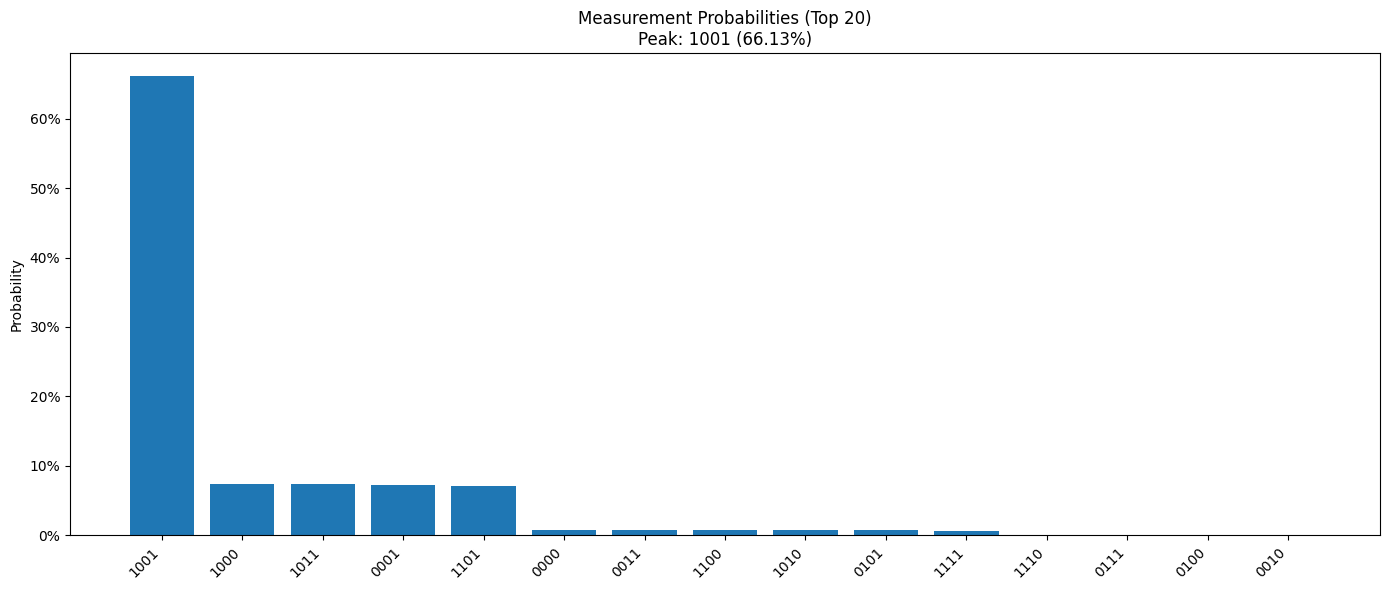


🎯 Most probable bitstring: 1001 (Probability: 66.13%)

✅ Analysis completed successfully!


In [ ]:
if __name__ == "__main__":
    analyzer1 = QuantumCircuitAnalyzer(
        ibm_token=ibm_token,
        backend_name="ibm_sherbrooke"
    )

    problem_path1 = problem_path + "P1_little_peak.qasm"

    # Run complete analysis
    result1 = analyzer1.full_analysis(
        qasm_file=problem_path1,
        shots=10000
    )

    if result1:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")

## Problem 2: Swift Rise 🌊

Points: 20

Accelerate your journey with this electrifying 28-qubit circuit


🔍 Starting Full Analysis for: /content/drive/MyDrive/Colab Notebooks/YQuantum2025/problem/P2_swift_rise.qasm
🔬 Shots: 10,000 | Optimization Level: 3
🌀 Loaded 28-qubit circuit with 2339 gates
✅ Optimization done: depth 91 → 94
📦 Job submitted (ID: czxr1dnrxz8g008f31eg)


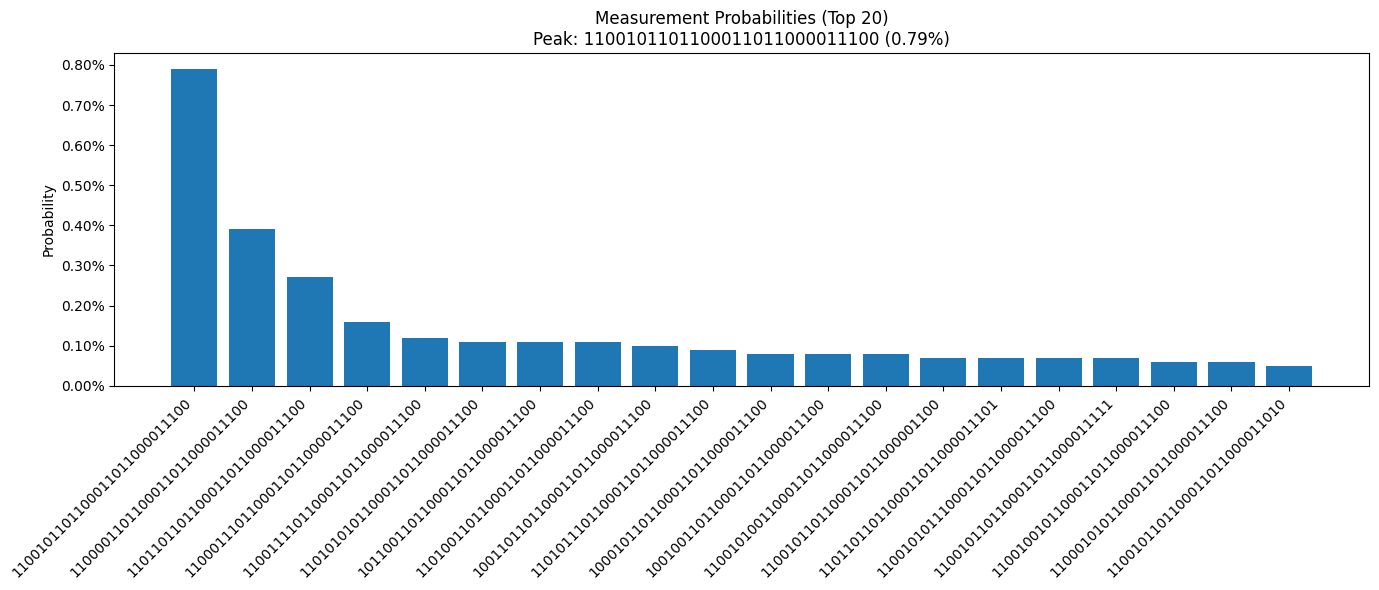


🎯 Most probable bitstring: 1100101101100011011000011100 (Probability: 0.79%)

✅ Analysis completed successfully!


In [ ]:
if __name__ == "__main__":
    analyzer2 = QuantumCircuitAnalyzer(
        ibm_token=ibm_token,
        backend_name="ibm_sherbrooke"
    )

    problem_path2 = problem_path + "P2_swift_rise.qasm"

    # Run complete analysis
    result2 = analyzer2.full_analysis(
        qasm_file=problem_path2,
        shots=10000
    )

    if result2:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")

## Problem 3: Sharp Peak 🏜

Points: 50

Conquer the frontier with this razor-sharp 44-qubit circuit, meticulously crafted to slice through classical barriers and redefine the quantum landscape


🔍 Starting Full Analysis for: /content/drive/MyDrive/Colab Notebooks/YQuantum2025/problem/P3_sharp_peak.qasm
🔬 Shots: 10,000 | Optimization Level: 3
🌀 Loaded 44-qubit circuit with 622 gates
✅ Optimization done: depth 20 → 54
📦 Job submitted (ID: czxr2esnhqag008tnsp0)


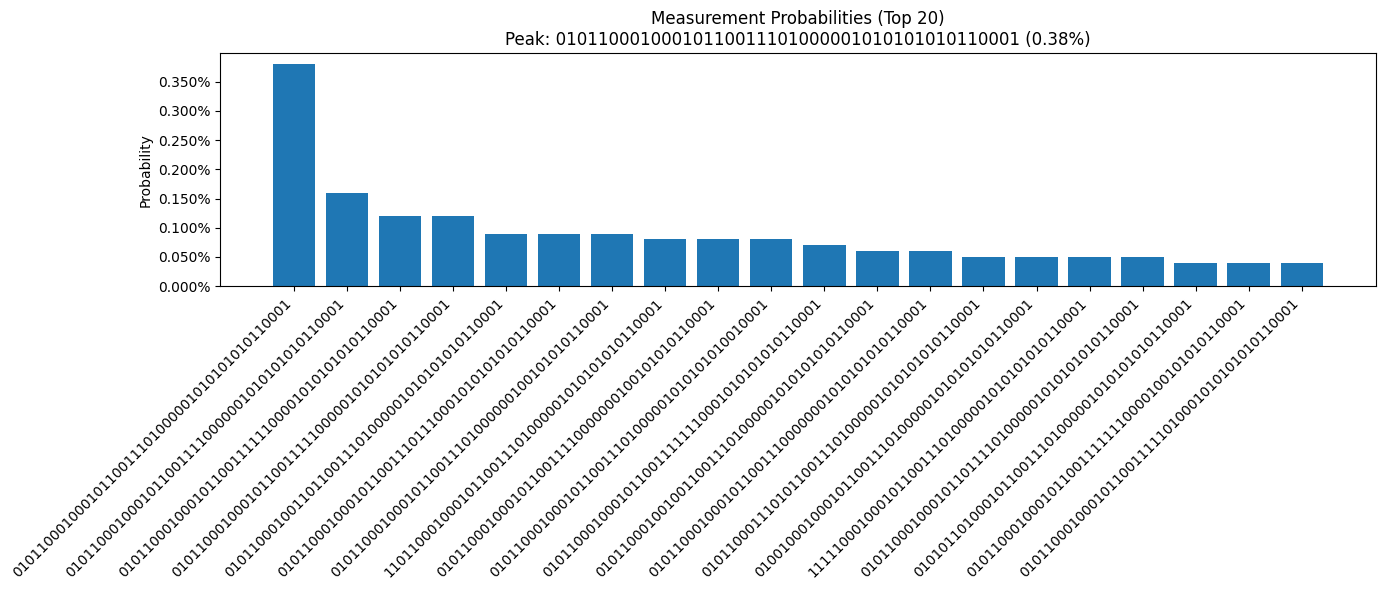


🎯 Most probable bitstring: 01011000100010110011101000001010101010110001 (Probability: 0.38%)

✅ Analysis completed successfully!


In [ ]:
if __name__ == "__main__":
    analyzer3 = QuantumCircuitAnalyzer(
        ibm_token=ibm_token,
        backend_name="ibm_sherbrooke"
    )

    problem_path3 = problem_path + "P3_sharp_peak.qasm"

    # Run complete analysis
    result3 = analyzer3.full_analysis(
        qasm_file=problem_path3,
        shots=10000
    )

    if result3:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")

## Problem 4: Golden Mountain ⛰️

Points: 100

Ascend to dazzling heights with this majestic 48-qubit circuit, where every connection gleams like a golden pathway to quantum brilliance!



In [128]:
if __name__ == "__main__":
    analyzer4 = QuantumCircuitAnalyzer(
        ibm_token=ibm_token,
        backend_name="ibm_sherbrooke"
    )

    problem_path4 = problem_path + "P4_golden_mountain.qasm"

    # Run complete analysis
    result4 = analyzer4.full_analysis(
        qasm_file=problem_path4,
    )

    if result4:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")

RequestsApiError: '400 Client Error: Bad Request for url: https://us-east.quantum-computing.cloud.ibm.com/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different execution mode <https://quantum.cloud.ibm.com/docs/guides/execution-modes>.","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"cvtr923jmtgc73fcqd3g"}\n'

## Problem 5: Granite Summit 🗻

Points: 200

Carve your legacy on this steadfast 44-qubit circuit, as enduring as granite itself, inviting you to seize the summit of quantum ingenuity!

In [ ]:
if __name__ == "__main__":
    analyzer5 = QuantumCircuitAnalyzer(bluequbit_token=bluequbit_token)
    problem_path5 = problem_path + "P5_granite_summit.qasm"
    # Run complete analysis
    result5 = analyzer5.full_analysis(
        qasm_file=problem_path5,
        shots=1  # More shots for better statistics on large circuits
    )

    if result5:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")

## Problem 6: Titan Pinnacle 🌋

Points: 290

Unleash a torrent of quantum power with this monumental 62-qubit circuit—a volcanic marvel that erupts with the explosive brilliance of technological innovation!

In [ ]:
if __name__ == "__main__":
    analyzer6 = QuantumCircuitAnalyzer(bluequbit_token=bluequbit_token)
    problem_path6 = problem_path + "P6_titan_pinnacle.qasm"
    # Run complete analysis
    result6 = analyzer6.full_analysis(
        qasm_file=problem_path6,
        shots=1  # More shots for better statistics on large circuits
    )

    if result6:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")